In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function simulate(prob, p, proj)
    tₛ, tₑ = prob.tspan
    sol = solve(
        remake(prob, p=p),
        RadauIIA5(),
        abstol=1e-14,
        reltol=1e-14,
        dense=false,
    )
    t_obs = sol.t[1:end]
    u_obs = vcat([(proj * u) for u in sol.u]...)
    return t_obs, u_obs
end

function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        push!(dfs, df)
    end
    return dfs
end

get_last_rows(trajectories) = vcat([DataFrame(t[end, :]) for t in trajectories]...)

θ = [Pair(:gNa, 25), Pair(:gK, 7)]
pkeys(θ) = map(θᵢ -> Symbol(θᵢ[1]), θ)
pvalues(θ) = map(θᵢ -> θᵢ[2], θ)

function where_converged(trajectories, threshold=5e-2)
    last_rows = get_last_rows(trajectories)
    pRMSEs = map(x -> rel_pRMSE(x, pvalues(θ)), eachrow(Array(last_rows[!, pkeys(θ)])))
    return pRMSEs .< 5e-2
end

function rel_pRMSE(θ_hat, θ)
    θ_hat = ndims(θ_hat) == 1 ? reshape(θ_hat, length(θ_hat), 1) : θ_hat
    MSE = sum(abs2, (θ_hat .- θ) ./ θ) / size(θ, 1)
    RMSE = sqrt.(MSE)
    return RMSE
end

rel_pRMSE (generic function with 1 method)

In [3]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 0.4 * HALF_WIDTH # inches

PT_PER_INCH = 72
HALF_WIDTH *= PT_PER_INCH
FULL_WIDTH *= PT_PER_INCH
HEIGHT *= PT_PER_INCH

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

PLOT_DEFAULTS = (titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)

(titlesize = 7, xlabelsize = 7, ylabelsize = 7, xticklabelsize = 7, yticklabelsize = 7, xticksize = 2, yticksize = 2)

In [4]:
BASE_PATH = RESULTS_PATH*"hh/2p/simple/"

tempering_schedule = reverse([10.0^x for x in 0:20])

metrics = []

max, max_idx = (0, 0)
for (i, T) in enumerate(tempering_schedule)
    fnames = readdir(BASE_PATH * "fenrir/compare_fixed_diff")
    fnames = fnames[map(x -> occursin("-$i-", x), fnames)]
    trajectories = import_csvs(BASE_PATH * "fenrir/compare_fixed_diff", fnames, [pkeys(θ)..., :κ², :loss, :T])
    conv = where_converged(trajectories)

    if mean(conv) > max
        max = mean(conv)
        max_idx = i
    end
    push!(metrics, conv)
end

# high, low, best κ²
metrics = [metrics[end], metrics[1], metrics[max_idx]]

# RK4
trajectories = import_csvs(BASE_PATH * "rk4/l2", readdir(BASE_PATH * "rk4/l2"), [pkeys(θ)..., :loss, :T])
metrics = [where_converged(trajectories), metrics...]

# optimal κ²
trajectories = import_csvs(BASE_PATH * "fenrir/opt_fixed_diff", readdir(BASE_PATH * "fenrir/opt_fixed_diff"), [pkeys(θ)..., :κ², :loss, :T])
push!(metrics, where_converged(trajectories))

# learned κ²
trajectories = import_csvs(BASE_PATH * "fenrir/learned_diff", readdir(BASE_PATH * "fenrir/learned_diff"), [pkeys(θ)..., :κ², :loss, :T])
push!(metrics, where_converged(trajectories))

# OURS
trajectories = import_csvs(BASE_PATH * "fenrir/tempered_diff", readdir(BASE_PATH * "fenrir/tempered_diff"), [pkeys(θ)..., :κ², :loss, :T])
push!(metrics, where_converged(trajectories))

println("best κ²= $(tempering_schedule[max_idx]) -> $(max*100)% correct")

best κ²= 1.0e16 -> 84.0% correct


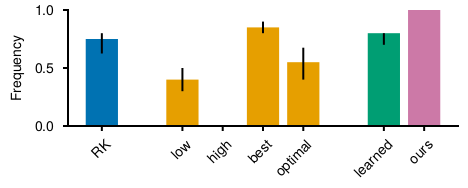

In [5]:
methods = ["RK", "low", "high", "best", "optimal", "learned", "ours"]

f = Figure(size=(HALF_WIDTH, HEIGHT), figure_padding=5)

pad = 1
pos = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
pos[2:end] .+= pad
pos[end-1:end] .+= pad
ax = Axis(f[1, 1], ylabel="Frequency", xticks=(pos, methods), xticklabelrotation=pi / 4; PLOT_DEFAULTS...)
colors = Makie.wong_colors()[1:4]
for (i, conv, c) in zip(pos, metrics, [colors[1], fill(colors[2], 4)..., colors[3], colors[4]])
    conv = vcat(conv, zeros(100 - size(conv, 1)))
    conv = reshape(conv, 10, 10)
    μ_conv = reshape(mean(conv, dims=1), :)
    m_conv = median(μ_conv)
    ql_conv = quantile(μ_conv, 0.25)
    qu_conv = quantile(μ_conv, 0.75)

    barplot!(ax, i, m_conv, color=c)
    errorbars!(ax, [i], [m_conv], [m_conv - ql_conv], [qu_conv - m_conv], color=:black, linewidth=1)
    # barplot!(ax, i, mean(μ_conv))
    # boxplot!(ax, fill(i, 10), μ_conv)
end
ylims!(ax, 0, 1)
hidedecorations!(ax, grid=true, label=false, ticklabels=false, ticks=false)
hidespines!(ax, :r, :t)
f

In [6]:
save(joinpath(FIGURES_PATH, "figure5.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}
